<a href="https://colab.research.google.com/github/PrettyTurtle201738639/Tube_challenge/blob/main/tube_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading source datasets

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import os

To run this notebook, please put the three csv files under your current working directory.

In [43]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/RLproject")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
os.chdir("/content/drive/My Drive/RLproject")

In [44]:
stations = pd.read_csv('stations.txt')
routes = pd.read_csv('routes.txt')
line_definitions = pd.read_csv('line_definitions.txt')

In [45]:
stations.head()

,id,latitude,longitude,name,display_name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2,0
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2,0
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2,0
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1,0
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1,0


In [46]:
routes.head()

,line,name,colour,stripe
0,1,Bakerloo Line,ab6612,NaN
1,3,Circle Line,f7dc00,NaN
2,6,Hammersmith & City Line,f5a6b3,NaN
3,7,Jubilee Line,767b7f,NaN
4,11,Victoria Line,0076bd,NaN


In [47]:
line_definitions.head()

,station1,station2,line
0,11,163,1
1,11,212,1
2,49,87,1
3,49,197,1
4,82,163,1


In [48]:
print("Number of stations:", len(stations))
print("Number of lines:", len(routes))
print("Number of connections:", len(line_definitions))

Number of stations: 308
Number of lines: 13
Number of connections: 415


describe the three tables

#Data: The London Underground Network

In [49]:
connections = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections = connections.iloc[0:0]

In [50]:
for index, row in line_definitions.iterrows():
  connections = connections.append({'line': row[2],
                                    'line_name': routes[routes['line']==row[2]]['name'].item(),
                                    'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                    'station1': row[0],
                                    'station1_name': stations[stations['id']==row[0]]['name'].item(),
                                    'station1_long': stations[stations['id']==row[0]]['longitude'].item(),
                                    'station1_lat': stations[stations['id']==row[0]]['latitude'].item(),
                                    'station1_zone': stations[stations['id']==row[0]]['zone'].item(),
                                    'station1_total_lines': stations[stations['id']==row[0]]['total_lines'].item(),
                                    'station1_rail': stations[stations['id']==row[0]]['rail'].item(),
                                    'station2': row[1],
                                    'station2_name': stations[stations['id']==row[1]]['name'].item(),
                                    'station2_long': stations[stations['id']==row[1]]['longitude'].item(),
                                    'station2_lat': stations[stations['id']==row[1]]['latitude'].item(),
                                    'station2_zone': stations[stations['id']==row[1]]['zone'].item(),
                                    'station2_total_lines': stations[stations['id']==row[1]]['total_lines'].item(),
                                    'station2_rail': stations[stations['id']==row[1]]['rail'].item(),
                                    }, ignore_index=True)

In [51]:
edgelist = connections[['station1', 'station2', 'line_colour']]
nodelist = stations[['id','latitude','longitude']]

In [52]:
g = nx.Graph()
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  

In [53]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [54]:
#Convert HEX colours to RGB colours
line_colours = {
        'ab6612': (171, 102, 18),
        '0076bd': (0, 118, 189),
        'f7dc00': (247, 220, 0),
        'f5a6b3': (245, 166, 179),
        '767b7f': (118, 123, 127),
        '0d6928': (0, 114, 41),
        'df002c': (220, 36, 31),
        '8b004c': (117, 16, 86),
        'f3ba22': (243, 186, 34),
        '000000': (0, 0, 0),
        '002d73': (0, 45, 115),
        '89cbc1': (137, 203, 193),
        '00A77E':(0,167,126)
}

# Convert RGB colours to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}

# Set these as options for drawing graph
options = {
    'edge_color': [line_colours[data['line_colour']] for u,v,data in g.edges(data=True)],
    'width': 1.5,
    'alpha': 1,
}

Text(0.5, 1.0, 'Graph Representation of London Underground Network')

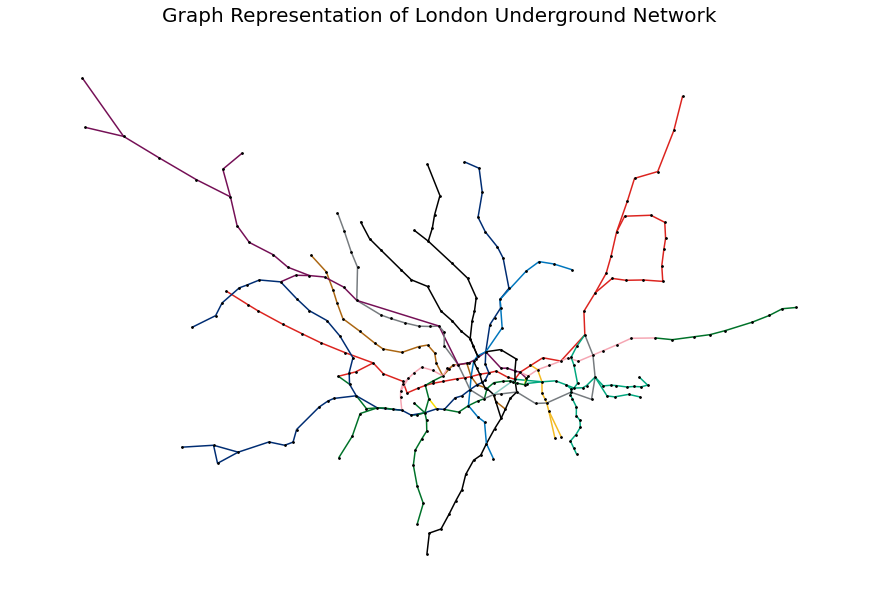

In [55]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, node_size=3, node_color='black', **options)
plt.title('Graph Representation of London Underground Network', size=20)

## Finding shortest journey between stations

Distance between stations is calculated from longitude and latitude with the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), which is a formula for calculating spherical distance.

In [56]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [57]:
distances=[]
for index, row in connections.iterrows():
  distances.append(distance(row[6], row[5], row[13], row[12]))
connections['distance'] = distances

In [58]:
graph_distance = nx.Graph()
for connection_id, connection in connections.iterrows():
    graph_distance.add_edge(connection['station1_name'], connection['station2_name'], weight = connection['distance'])

In [59]:
for i in ['Holborn', 'Euston']:
  print(f"\n{i} station is directly connected to:", *list(graph_distance.neighbors(i)), sep='\n\t', )


Holborn station is directly connected to:
	Chancery Lane
	Tottenham Court Road
	Covent Garden
	Russell Square

Euston station is directly connected to:
	Camden Town
	King's Cross St. Pancras
	Mornington Crescent
	Warren Street


In [60]:
def shortest_route(start, end):
    journey_path = nx.shortest_path(graph_distance, start, end, weight='weight')
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    print(f'\nShortest Tube-Distance Journey from {start} to {end}:', *journey_path, sep='\n\t')
    print('\nJourney Distance:', journey_distance, 'kilometers')

In [61]:
shortest_route('Waterloo', 'Euston')


Shortest Tube-Distance Journey from Waterloo to Euston:
	Waterloo
	Embankment
	Charing Cross
	Leicester Square
	Tottenham Court Road
	Goodge Street
	Warren Street
	Euston

Journey Distance: 3.4763636864651986 kilometers


In [62]:
#Jubilee goes directly from Canary Wharf to Covent Garden, and it takes 30 min on Google Maps,
#This shortest_distance journey includes 2 changes, from DLR ==> Central ==> Piccadily, and takes 34 min on Google Maps
shortest_route('Canary Wharf', 'Covent Garden')


Shortest Tube-Distance Journey from Canary Wharf to Covent Garden:
	Canary Wharf
	West India Quay
	Westferry
	Limehouse
	Shadwell
	Bank
	St. Paul's
	Chancery Lane
	Holborn
	Covent Garden

Journey Distance: 7.96831555899172 kilometers


# Data Preprocessing

###Split stations to station*line(platforms) to address transit cost:

In [63]:
stations_ = stations
stations_['line']=range(len(stations_.index))

In [64]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

In [65]:
ilist=[]
for i in range(1,310):
  try:
    stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
  except:
    ilist.append(i)
    pass
ilist

[95, 150, 227, 254]

In [66]:
for i in ilist:
  print(stations_.loc[stations_['id']==i, 'total_lines'])

78    1
Name: total_lines, dtype: int64
131    1
Name: total_lines, dtype: int64
198    1
Name: total_lines, dtype: int64
223    2
367    2
Name: total_lines, dtype: int64


In [67]:
for i in ilist:
  print(np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique()))))

[10 11]
[3 6]
[3 6]
[7]


In [68]:
stations_ = stations
stations_['line']=range(len(stations_.index))

In [69]:
stations.loc[stations['id']==95, 'total_lines'] = 2 
stations.loc[stations['id']==150, 'total_lines'] = 2 
stations.loc[stations['id']==227, 'total_lines'] = 2 
stations.loc[stations['id']==254, 'total_lines'] = 1 

In [70]:
two_lines = stations[stations['total_lines'] > 1]
three_lines = stations[stations['total_lines'] > 2]
four_lines = stations[stations['total_lines'] > 3]
five_lines = stations[stations['total_lines'] > 4]
six_lines = stations[stations['total_lines'] > 5]
stations_ = stations_.append([two_lines],ignore_index=True)
stations_ = stations_.append([three_lines],ignore_index=True)
stations_ = stations_.append([four_lines],ignore_index=True)
stations_ = stations_.append([five_lines],ignore_index=True)
stations_ = stations_.append([six_lines],ignore_index=True)

In [71]:
ilist=[]
for i in range(1,310):
  try:
    stations_.loc[stations_['id']==i, 'line'] = np.unique(np.concatenate((line_definitions[line_definitions['station1']==i]['line'].unique(), line_definitions[line_definitions['station2']==i]['line'].unique())))
  except:
    ilist.append(i)
ilist

[]

## dropping DLR

In [72]:
tubes = stations_[stations_['line']<13]

In [ ]:
tubes['idx']= range(len(tubes.index))

###making a connections dataframe with station*lines(platform) index

In [74]:
line_definitions_ = pd.DataFrame(columns=['station1',	'station2',	'line']).iloc[0:0]

In [ ]:
for index, row in line_definitions.iterrows():
  try:
    line_definitions_ = line_definitions_.append({'station1': tubes.loc[tubes['id']==row[0]][tubes['line']==row[2]]['idx'].item(),
                                                'station2': tubes.loc[tubes['id']==row[1]][tubes['line']==row[2]]['idx'].item(),
                                                'line': row[2]}, ignore_index=True)
  except:
    pass

In [94]:
connections_ = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station1_zone', 'station1_total_lines',	'station1_rail', 'station2', 'station2_name', 'station2_long','station2_lat', 'station2_zone', 'station2_total_lines',	'station2_rail'])
connections_ = connections.iloc[0:0]

In [78]:
for index, row in line_definitions_.iterrows():
  connections_ = connections_.append({'line': row[2],
                                      'line_name': routes[routes['line']==row[2]]['name'].item(),
                                      'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                      'station1': row[0],
                                      'station1_name': tubes[tubes['idx']==row[0]]['name'].item(),
                                      'station1_long': tubes[tubes['idx']==row[0]]['longitude'].item(),
                                      'station1_lat': tubes[tubes['idx']==row[0]]['latitude'].item(),
                                      'station1_zone': tubes[tubes['idx']==row[0]]['zone'].item(),
                                      'station1_total_lines': tubes[tubes['idx']==row[0]]['total_lines'].item(),
                                      'station1_rail': tubes[tubes['idx']==row[0]]['rail'].item(),
                                      'station2': row[1],
                                      'station2_name': tubes[tubes['idx']==row[1]]['name'].item(),
                                      'station2_long': tubes[tubes['idx']==row[1]]['longitude'].item(),
                                      'station2_lat': tubes[tubes['idx']==row[1]]['latitude'].item(),
                                      'station2_zone': tubes[tubes['idx']==row[1]]['zone'].item(),
                                      'station2_total_lines': tubes[tubes['idx']==row[1]]['total_lines'].item(),
                                      'station2_rail': tubes[tubes['idx']==row[1]]['rail'].item(),
                                      }, ignore_index=True)

In [79]:
distances=[]
for index, row in connections_.iterrows():
  distances.append(distance(row[6], row[5], row[13], row[12]))
connections_['distance'] = distances

In [80]:
connections__ = connections_[['station1', 'station1_name','station2', 'station2_name', 'distance']]

In [81]:
for i in range(1, 385):
  test_list = tubes[tubes['id']==i]['idx'].tolist()
  for j in [(a, b) for idx, a in enumerate(test_list) for b in test_list[idx + 1:]]:
    connections__ = connections__.append({'station1': j[0],
                                          'station1_name': tubes[tubes['idx']==j[0]]['name'].item(),
                                          'station2': j[1],
                                          'station2_name': tubes[tubes['idx']==j[1]]['name'].item(),
                                          'distance': 1
                                          }, ignore_index=True)

# Transforming to TSP problem

[the other notebook](https://colab.research.google.com/drive/1O_HJeNMZtpzEMX3Wx9e2DW_GCEe4ax2X?usp=sharing)

shortest path algorithm to fill distance matrix

In [82]:
distance_x = np.zeros((275, 275))

In [83]:
graph_distance = nx.Graph()
for connection_id, connection in connections__.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [84]:
def distance(start, end):
    journey_distance = nx.shortest_path_length(graph_distance, start, end, weight='weight')
    return journey_distance

In [89]:
id275 = tubes_unique['id'].to_list()
index = range(0, 275)
id_dict = dict(zip(id275, index))

In [90]:
for i in range(0, 384):
  for j in range(0, 384):
    distance_x[id_dict[tubes[tubes['idx']==i]['id'].item()], id_dict[tubes[tubes['idx']==j]['id'].item()]] = distance(i, j)

In [91]:
distance_x = np.load('distance_x.npy')

#baseline random policy

In [ ]:
for r in range(0, 10):
  episodes = 1000
  total_distances = []
  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    step = 0
    done = False
    while not done:     
      #choosing action
      a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]
      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True
      #update state
      s = a
      done = all(value == True for value in completed.values())
      step += 1
    total_distances.append(total_distance)
  #np.save('values/random/distances_r{}.npy'.format(r), total_distances) 

In [ ]:
Distances = np.zeros((10, 1000))
for i in range(1,10):
   Distances[i] = np.load('values/random/distances_r{}.npy'.format(i)) 
total_distance_random = np.average(Distances, axis=0)

Text(0.5, 0, 'episodes')

Text(0, 0.5, 'total distance / kilometers')

Text(0.5, 1.0, 'Total Distance on episodes, averaged over 10 runs')

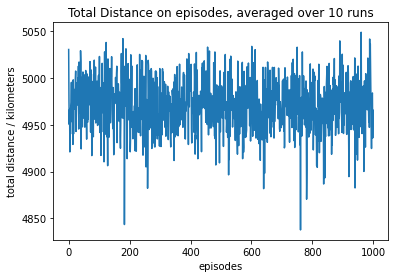

In [ ]:
plt.plot(total_distance_random)
plt.xlabel('episodes')
plt.ylabel('total distance / kilometers')
plt.title('Total Distance on episodes, averaged over 10 runs')
plt.show()

## Q learning result

In [ ]:
def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

In [ ]:
def run_q(episodes, epsilon_decay):
  total_distances = []
  #q values lookup table
  Q = np.zeros((275, 275))
  epsilon = 1
  epsilon_min = 0.01
  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    done = False
    #epsilon decay
    if epsilon > epsilon_min:
      epsilon *= epsilon_decay

    while not done:     
      #the q 
      q = np.copy(Q[s,:])
      q[states_memory] = -np.inf

      #choosing action base on epsilon greedy policy
      if np.random.rand() > epsilon:
        a = np.argmax(q)
      else:
        a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]

      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True

      #update q values ('action' = 'next_state')
      Q[s, a] = q_learning(Q[s, a], Q[a, :], -distance)

      #update state
      s = a
      done = all(value == True for value in completed.values())
    total_distances.append(total_distance)
  return total_distances, Q

## Double Q- learning

In [ ]:
def run_dq(episodes, epsilon_decay):
  epsilon_min = 0.01
  total_distances = []

  #q values lookup table
  Q1 = np.zeros((275, 275))
  Q2 = np.zeros((275, 275))
  epsilon = 1

  for i in range(episodes):
    #initialize with a starting state
    s = 0
    total_distance = 0
    #making a 'completed' dict
    keys = range(0, 275)
    completed = dict(zip(keys, [False] * 275))
    states_memory = [s]
    completed[s] = True
    done = False
    #epsilon decay
    if epsilon > epsilon_min:
      epsilon *= epsilon_decay

    while not done:     
      #the q 
      q1 = np.copy(Q1[s,:])
      q2 = np.copy(Q2[s,:])
      q = q1+q2
      q[states_memory] = -np.inf

      #choosing action base on epsilon greedy policy
      if np.random.rand() > epsilon:
        a = np.argmax(q)
      else:
        a = np.random.choice([x for x in range(275) if x not in states_memory])
      distance = distance_x[s, a]

      #update distance and 'completed' dict
      total_distance += distance
      states_memory.append(a)
      completed[a] = True

      #update q values ('action' = 'next_state')

      if np.random.binomial(1, 0.5) == 1:
        Q1[s, a] = q_learning(Q1[s, a], Q2[a, :], -distance)
      else:
        Q2[s, a] = q_learning(Q2[s, a], Q1[a, :], -distance)

      #update state
      s = a
      done = all(value == True for value in completed.values())
      step += 1
    total_distances.append(total_distance)
  return total_distances, Q1, Q2

#Deep Q-Network

In [ ]:
from IPython.display import clear_output
from collections import deque
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_compile_model():
    model = Sequential()
    model.add(Embedding(1, 275, input_length=1))
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(275, activation='linear'))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [ ]:
q_network = build_compile_model()
target_network = build_compile_model()

In [ ]:
episodes = 1
epsilon_decay = 0.99
batch_size = 16
total_distances = []
expirience_replay = deque(maxlen=200)
epsilon = 1
epsilon_min = 0.01

for i in range(episodes):
  #initialize with a starting state
  s = 0
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] *275))
  states_memory = [s]
  completed[s] = True
  done = False
  #epsilon decay
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay      
  while not done:    
    if np.random.rand() > epsilon: 
      q = q_network.predict(np.array([s]))
      q[0][0][states_memory] = -np.inf
      a = np.argmax(q)
    else:
      a = np.random.choice(np.array([x for x in range(275) if x not in states_memory]))
    distance = distance_x[s, a]
    states_memory.append(a)
    total_distance += distance
    completed[a] = True
    done = all(value == True for value in completed.values())
    expirience_replay.append((s, a, -distance, a, done))
    if done:
        target_network.set_weights(q_network.get_weights())          
    if len(expirience_replay) > batch_size:
        minibatch = random.sample(expirience_replay, batch_size)
        for state, action, reward, next_state, terminated in minibatch:
            target = q_network.predict(np.array([state]))
            if terminated == True:
                target[0][0][action] = reward
            else:
                t = target_network.predict(np.array([next_state]))
                target[0][0][action] = reward + 0.1 * np.amax(t)
            q_network.fit(np.array([state]), target, epochs=1, verbose=0)
    #update state
    s = a
  total_distances.append(total_distance)

In [ ]:
run_dqn(1, 0.5, 16, q_network, target_network)

0


5481.146798838891

## Experimental Results

####loading saved distances and Q values

In [ ]:
Distances = np.zeros((10, 1000))
for i in range(0,10):
   Distances[i] = np.load('values/q/distances_r{}.npy'.format(i)) 
total_distance_q1000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 1000))
for i in range(0,10):
   Distances[i] = np.load('values/double_q/distances_r{}.npy'.format(i)) 
total_distance_dq1000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 2000))
for i in range(0,10):
   Distances[i] = np.load('values/q/distances_2000_r{}.npy'.format(i)) 
total_distance_q2000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 2000))
for i in range(0,10):
   Distances[i] = np.load('values/double_q/distances_2000_r{}.npy'.format(i)) 
total_distance_dq2000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 4000))
for i in range(0,10):
   Distances[i] = np.load('values/4000/distances_q_r{}.npy'.format(i)) 
total_distance_q4000 = np.average(Distances, axis=0)

Distances = np.zeros((10, 4000))
for i in range(0,10):
   Distances[i] = np.load('values/4000/distances_dq_r{}.npy'.format(i)) 
total_distance_dq4000 = np.average(Distances, axis=0)

In [95]:
Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i-1] = np.load('values/q/Q_r{}.npy'.format(i)) 
Q_q1000_avg = np.average(Q, axis=0)

Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i-1] = np.load('values/q/Q_2000_r{}.npy'.format(i)) 
Q_q2000_avg = np.average(Q, axis=0)

Q = np.zeros((10, 275, 275))
for i in range(0,10):
  Q[i-1] = np.load('values/4000/Q_4000_r{}.npy'.format(i)) 
Q_q4000_avg = np.average(Q, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(0,10):
  Q1[i-1] = np.load('values/double_q/q1_r{}.npy'.format(i)) 
  Q2[i-1] = np.load('values/double_q/q2_r{}.npy'.format(i)) 
Q_dq1000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(0,10):
  Q1[i-1] = np.load('values/double_q/q1_2000_r{}.npy'.format(i)) 
  Q2[i-1] = np.load('values/double_q/q2_2000_r{}.npy'.format(i)) 
Q_dq2000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

Q1 = np.zeros((10, 275, 275))
Q2 = np.zeros((10, 275, 275))
for i in range(1,10):
  Q1[i-1] = np.load('values/4000/q1_r{}.npy'.format(i)) 
  Q2[i-1] = np.load('values/4000/q2_r{}.npy'.format(i)) 
Q_dq4000_avg = np.average(Q1, axis=0) + np.average(Q2, axis=0)

####plotting total distances over episodes for Q and double Q learning


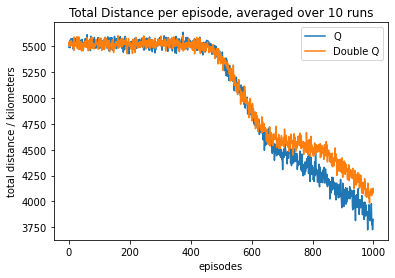

In [ ]:
plt.plot(total_distance_q1000, label="Q")
plt.plot(total_distance_dq1000, label="Double Q")
plt.xlabel('episodes')
plt.ylabel('total distance / kilometers')
plt.legend(loc="upper right")
plt.title('Total Distance per episode, averaged over 10 runs')
plt.show()

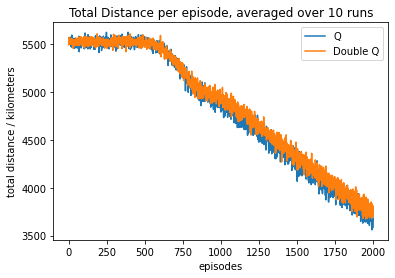

In [ ]:
plt.plot(total_distance_q2000, label="Q")
plt.plot(total_distance_dq2000, label="Double Q")
plt.xlabel('episodes')
plt.ylabel('total distance / kilometers')
plt.legend(loc="upper right")
plt.title('Total Distance per episode, averaged over 10 runs')
plt.show()

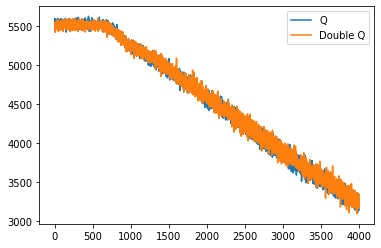

In [ ]:
plt.plot(total_distance_q4000, label="Q")
plt.plot(total_distance_dq4000, label="Double Q")
plt.legend(loc="upper right")

### solution under each method

In [ ]:
def ideal_distance(Q, s):
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = []
  completed[s] = True
  done = False

  while not done:     
    #the q 
    q = np.copy(Q[s,:])
    q[states_memory] = -np.inf
    a = np.argmax(q)
    distance = distance_x[s, a]
    
    #update distance and 'completed' dict
    total_distance += distance
    states_memory.append(s)
    completed[s] = True
    #update state
    s = a
    done = all(value == True for value in completed.values())
  return total_distance

In [96]:
def ideal_route(Q, s):
  total_distance = 0
  #making a 'completed' dict
  keys = range(0, 275)
  completed = dict(zip(keys, [False] * 275))
  states_memory = []
  completed[s] = True
  done = False

  while not done:     
    #the q 
    q = np.copy(Q[s,:])
    q[states_memory] = -np.inf
    a = np.argmax(q)
    distance = distance_x[s, a]
    
    #update distance and 'completed' dict
    total_distance += distance
    states_memory.append(s)
    completed[s] = True
    #update state
    s = a
    done = all(value == True for value in completed.values())
  return states_memory

In [ ]:
ideal_distances =[]
for i in range(0,10):
  Q1 = np.load('values/4000/q1_r{}.npy'.format(i))
  Q2 = np.load('values/4000/q2_r{}.npy'.format(i))
  Q = Q1 + Q2
  ideal_distances.append(ideal_distance(Q, 273))
sum(ideal_distances)/len(ideal_distances)

792.7585233812364

In [ ]:
ideal_distances =[]
for i in range(0,10):
  Q = np.load('values/q/Q_r{}.npy'.format(i))
  ideal_distances.append(ideal_distance(Q, 273))
sum(ideal_distances)/len(ideal_distances)

1209.175678047517

In [ ]:
ideal_distance(Q_dq4000_avg, 273)

689.552794718224


<center>Distance of Best Route Starting from Heathrow Terminal 5, </center>

<center>under greedy policy maximizing Q values, in kilometers</center>


|                               |   Q-Learning  | Double Q-Learning |
| -----------                   |  -----------  |-------------------|
| <center>1000 episodes</center>| <center>1209.2 </center> | <center>1519.6</center>
|  <center>2000 episodes</center>| <center> 849.3 </center>| <center>957.2</center>
|  <center>4000 episodes</center>|<center> 742.8</center>|<center>792.8 </center>

<center>Distance of Best Route Starting from Heathrow Terminal 5, </center><center>under greedy policy maximizing Q values averaged from 10 runs, in kilometers</center>

|                               |   Q-Learning  | Double Q-Learning |
| -----------                   |  -----------  |-------------------|
|  <center>1000 episodes, 10 runs</center>|<center>730.5</center>| <center>766.8</center>
|  <center>2000 episodes, 10 runs</center>|<center>712.7</center>| <center>696.6</center>
|  <center>4000 episodes, 10 runs</center>|<center>  687.5 </center>|<center> 689.6</center>

### recover the routes

In [97]:
routes = pd.read_csv('routes.txt')

In [98]:
connections_t = pd.DataFrame(columns=['line',	'line_name',	'line_colour', 'station1', 'station1_name', 'station1_long','station1_lat', 'station2', 'station2_name', 'station2_long','station2_lat'])
connections_t = connections_t.iloc[0:0]
for index, row in line_definitions[line_definitions['line']<13].iterrows():
  connections_t = connections_t.append({'line': row[2],
                                        'line_name': routes[routes['line']==row[2]]['name'].item(),
                                        'line_colour': routes[routes['line']==row[2]]['colour'].item(),
                                        'station1': tubes_unique[tubes_unique['id']==row[0]]['id'].item(),
                                        'station1_name': tubes_unique[tubes_unique['id']==row[0]]['name'].item(),
                                        'station1_long': tubes_unique[tubes_unique['id']==row[0]]['longitude'].item(),
                                        'station1_lat': tubes_unique[tubes_unique['id']==row[0]]['latitude'].item(),
                                        'station2': tubes_unique[tubes_unique['id']==row[1]]['id'].item(),
                                        'station2_name': tubes_unique[tubes_unique['id']==row[1]]['name'].item(),
                                        'station2_long': tubes_unique[tubes_unique['id']==row[1]]['longitude'].item(),
                                        'station2_lat': tubes_unique[tubes_unique['id']==row[1]]['latitude'].item(),
                                        }, ignore_index=True)


In [99]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))
distances=[]
for index, row in connections_t.iterrows():
  distances.append(distance(row[6], row[5], row[10], row[9]))
connections_t['distance'] = distances

In [100]:
graph_distance = nx.Graph()
for connection_id, connection in connections_t.iterrows():
    graph_distance.add_edge(connection['station1'], connection['station2'], weight = connection['distance'])

In [101]:
edgelist = connections_t[['station1', 'station2', 'line_colour', 'distance']]
nodelist = tubes_unique[['id','latitude','longitude']]

In [102]:
g = nx.Graph()
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())
for i, nlrow in nodelist.iterrows():
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  

In [103]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}
node_positions = {node[0]: (node[1]['longitude'], node[1]['latitude']) for node in list(g.nodes(data=True))}

In [104]:
line_colours = {
        'ab6612': (171, 102, 18),
        '0076bd': (	0, 118, 189),
        'f7dc00': (247, 220, 0),
        'f5a6b3': (245, 166, 179),
        '767b7f': (	118, 123, 127),
        '0d6928': (0, 114, 41),
        'df002c': (220, 36, 31),
        '8b004c': (117, 16, 86),
        'f3ba22': (243, 186, 34),
        '000000': (0, 0, 0),
        '002d73': (0, 45, 115),
        '89cbc1': (137, 203, 193)
}

# Convert RGB to [0,1] scale
line_colours = {line: tuple([x / 255.0 for x in rgb]) for line, rgb in line_colours.items()}
options = {
    'edge_color': [line_colours[data['line_colour']] for u,v,data in g.edges(data=True)],
    'width': 1.5,
    'alpha': 1,
}

In [105]:
def shortest_route(journey):
  route = []
  i = 0
  for x in journey:
    if i < len(journey)-1:
      route.append(nx.shortest_path(graph_distance, journey[i], journey[i+1], weight='weight')[1:])
    i += 1
  return route

In [106]:
def unpack(journey):
  journey_ = []
  for stop in journey:
    if stop not in journey_:
          journey_.append(stop)

  index =range(0,275)
  id275 = tubes_unique['id'].to_list()
  idx_dict = dict(zip(index, id275))

  journey = []
  for stop in journey_:
    journey.append(idx_dict[stop])

  route = shortest_route(journey)
  route = [item for items in route for item in items]

  route_ = []
  #add first stop heathrow terminal five to the routes 
  route_.append(308)
  for stop in route:
    route_.append(stop)

  route_e = []
  for i in range(0, len(route_)-1):
    route_e.append(route_[i+1])
  routes = pd.DataFrame(columns=['station1',	'station2'])
  routes['station1'] = route_[0:len(route_)-1]
  routes['station2'] = route_e

  name = tubes_unique['name'].to_list()
  name_dict = dict(zip(id275, name))
  return routes

In [109]:
def draw_png(image_path, routes):
  edge_cnter = {}
  g_i_edge_colors = []

  for i, j in routes.iterrows():
      plt.figure(figsize=(6, 4))
      nx.draw(g, pos=node_positions, node_size=4, node_color='black', **options)
      #plt.title('1000 episodes', size=20)
      routes_i = routes[0:i]
      for i in range(len(routes_i)):
          edge_i = frozenset([routes_i.iloc[i][0], routes_i.iloc[i][1]])
      g_i = nx.Graph()
      for i, elrow in routes_i.iterrows():
        g_i.add_edge(elrow[0], elrow[1])
      nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=4, alpha=0.9, node_color='white')
      nx.draw_networkx_edges(g_i, pos=node_positions, edge_color='white', alpha=0.6, width =1.5)
      plt.axis('off') 
      plt.savefig(image_path + 'img{}.png'.format(i), dpi=120, bbox_inches='tight')
      plt.close()

In [110]:
draw_png(unpack(ideal_route(Q_q4000_avg, 273)), 'png_q4000_avg/')

In [122]:
import glob
import imageio
def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]
    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [123]:
make_circuit_video('png_q4000_avg/', 'route_animation_q4000.gif', fps=5)

In [135]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)